In [1]:
import numpy as np
import os
import cv2
from tqdm import tqdm
from matplotlib import pyplot as plt
import torch
from super_gradients.training import models
import glob
from scipy.optimize import linear_sum_assignment, least_squares
import time
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import torchvision.transforms as T
import random

/home/yh6917/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[2023-05-18 19:26:56] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /home/yh6917/sg_logs/console.log


2023-05-18 19:26:57.274737: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-18 19:26:57.421241: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-18 19:26:57.904899: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/yh6917/.local/lib/python3.10/site-packages/cv2/../../lib64:/home/yh6917/nuws/inst

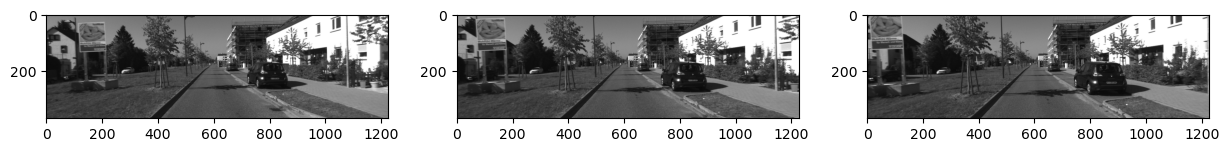

In [67]:
# read 3 frames of images
img_path1 = 'KITTI_sequence_1/image_l/000001.png'
img_path2 = 'KITTI_sequence_1/image_l/000002.png'
img_path3 = 'KITTI_sequence_1/image_l/000003.png'
img1 = cv2.imread(img_path1)
img2 = cv2.imread(img_path2)
img3 = cv2.imread(img_path3)
# show images
plt.figure(figsize=(15, 15))
plt.subplot(131)
plt.imshow(img1)
plt.subplot(132)
plt.imshow(img2)
plt.subplot(133)
plt.imshow(img3)
plt.show()

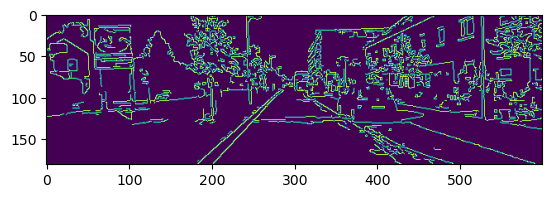

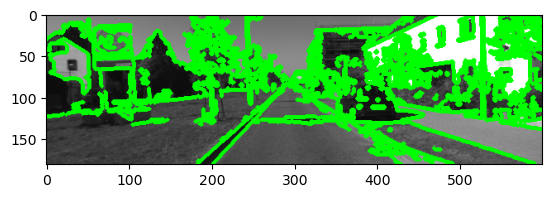

In [71]:
# Resize the image to have a maximum of 800 pixels in any dimension
max_dimension = max(img1.shape)
scale = 600 / max_dimension
img1 = cv2.resize(img1, None, fx=scale, fy=scale)
edges = cv2.Canny(img1, 100, 200)
plt.imshow(edges)
plt.show()
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# show the contours
img1_contours = img1.copy()
cv2.drawContours(img1_contours, contours, -1, (0, 255, 0), 3)
plt.imshow(img1_contours)
plt.show()

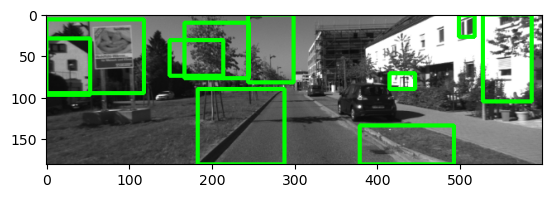

In [73]:
rois = []
for contour in contours:
    # filter contours by area
    area = cv2.contourArea(contour)
    if area > 100.0:
        x, y, w, h = cv2.boundingRect(contour)
        rois.append([x, y, w, h])
"""
# get rid of smaller rois that are inside larger ones
rois = np.array(rois)
rois = rois[np.argsort(rois[:, 2] * rois[:, 3])][::-1]
rois = rois.tolist()
for i in range(len(rois)):
    for j in range(i + 1, len(rois)):
        if rois[i] is not None and rois[j] is not None:
            x1, y1, w1, h1 = rois[i]
            x2, y2, w2, h2 = rois[j]
            if x1 >= x2 and y1 >= y2 and (x1 + w1) <= (x2 + w2) and (y1 + h1) <= (y2 + h2):
                rois[i] = None
rois = [roi for roi in rois if roi is not None]
# show the rois
"""
img1_rois = img1.copy()
for roi in rois:
    x, y, w, h = roi
    cv2.rectangle(img1_rois, (x, y), (x + w, y + h), (0, 255, 0), 3)
plt.imshow(img1_rois)
plt.show()


In [74]:
# package the above code into a class
class ROI:
    def __init__(self, max_dimension=800, roi_threshold_low=100, roi_threshold_high=500, canny_low=100, canny_high=200) -> None:
        self.rois = []
        self.max_dimension = max_dimension
        self.roi_threshold_low = roi_threshold_low
        self.roi_threshold_high = roi_threshold_high
        self.canny_low = canny_low
        self.canny_high = canny_high
    
    def get_rois(self, img):
        max_dimension = max(img.shape)
        scale = self.max_dimension / max_dimension
        my_img = cv2.resize(img, None, fx=scale, fy=scale)
        edges = cv2.Canny(my_img, self.canny_low, self.canny_high)
        contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        rois = []
        for contour in contours:
            # filter contours by area
            area = cv2.contourArea(contour)
            if area > self.roi_threshold_low and area < self.roi_threshold_high:
                x, y, w, h = cv2.boundingRect(contour)
                rois.append([x, y, w, h])
        return rois

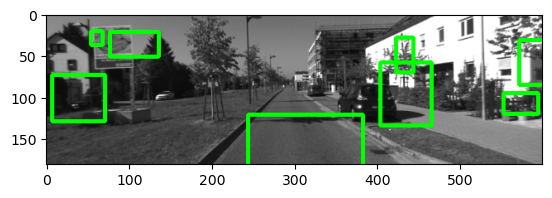

In [75]:
# test the class
roi = ROI()
rois = roi.get_rois(img1)
img1_rois = img1.copy()
for roi in rois:
    x, y, w, h = roi
    cv2.rectangle(img1_rois, (x, y), (x + w, y + h), (0, 255, 0), 3)
plt.imshow(img1_rois)
plt.show()

In [76]:
rois[0]

[244, 121, 139, 120]